In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors
import lib.utils.ez_priors

In [2]:
patient_id = 'id004_bj'
szr_name = 'BJcrise1le161128B-BEX_0002'


'''
patient_id = 'id001_bt'
szr_name = 'BTcrise2appportable_0013'

patient_id = 'id003_mg'
szr_name = 'MGcrise1'

patient_id = 'id010_cmn'
szr_name = 'CMN_crise4P_140320B-DEX_0008'


patient_id = 'id017_mk'
szr_name = "MK_crise1Part1_170328C-BEX_0004_MK_crise1Part2_170328C-BEX_0007"


patient_id = 'id020_lma'
szr_name = 'LM_crise3P_100415b-bex_0005'

patient_id = 'id025_mc'
szr_name = 'MC_C1_Part1_080429ccex_0002_MC_C1_Part2_080429ccex_0003'

patient_id = 'id050_sx'
szr_name = 'SX_C4P_111202C-EEX_0002'


patient_id = 'id022_te'
szr_name = 'TE_crise2P_130306C-BEX_0000'


patient_id = 'id027_sj'
szr_name = 'SJ_crise1PSG_120214D-CEX_0003'


patient_id = 'id030_bf'
szr_name = 'BF_crise1P_110831B-CEX_0004'

patient_id = 'id039_mra'
szr_name = 'MR_C4P_170124b-cex_0028'


patient_id = 'id013_lk'
szr_name = 'LK_crise1P_160707A-AEX_0013'


patient_id = 'id014_vc'
szr_name = 'VC_crise2P_131127C-EEX_0002'

'''

data_dir = f'datasets/retro/{patient_id}'
results_dir = f'results/exp10/exp10.68/{patient_id}'

meta_data_fname = f'{szr_name}.json'

fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)
os.makedirs(f'{results_dir}/optima', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.05
raw_seeg_fname = f'{szr_name}.raw.fif'
data = retro_prepare.prepare_data_bip(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found


### Compute epileptogenicity index

Isotrak not found
['Right-STS-anterior', 'Right-Collateral-sulcus', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Hippocampus-anterior', 'Right-Hippocampus-posterior']
[121, 131, 133, 134, 153, 154]
('C1', 30)
(array([153, 154, 155]),)


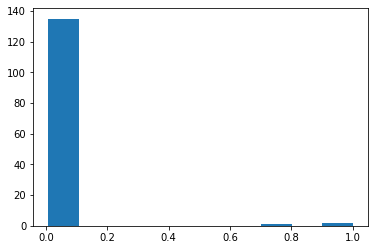

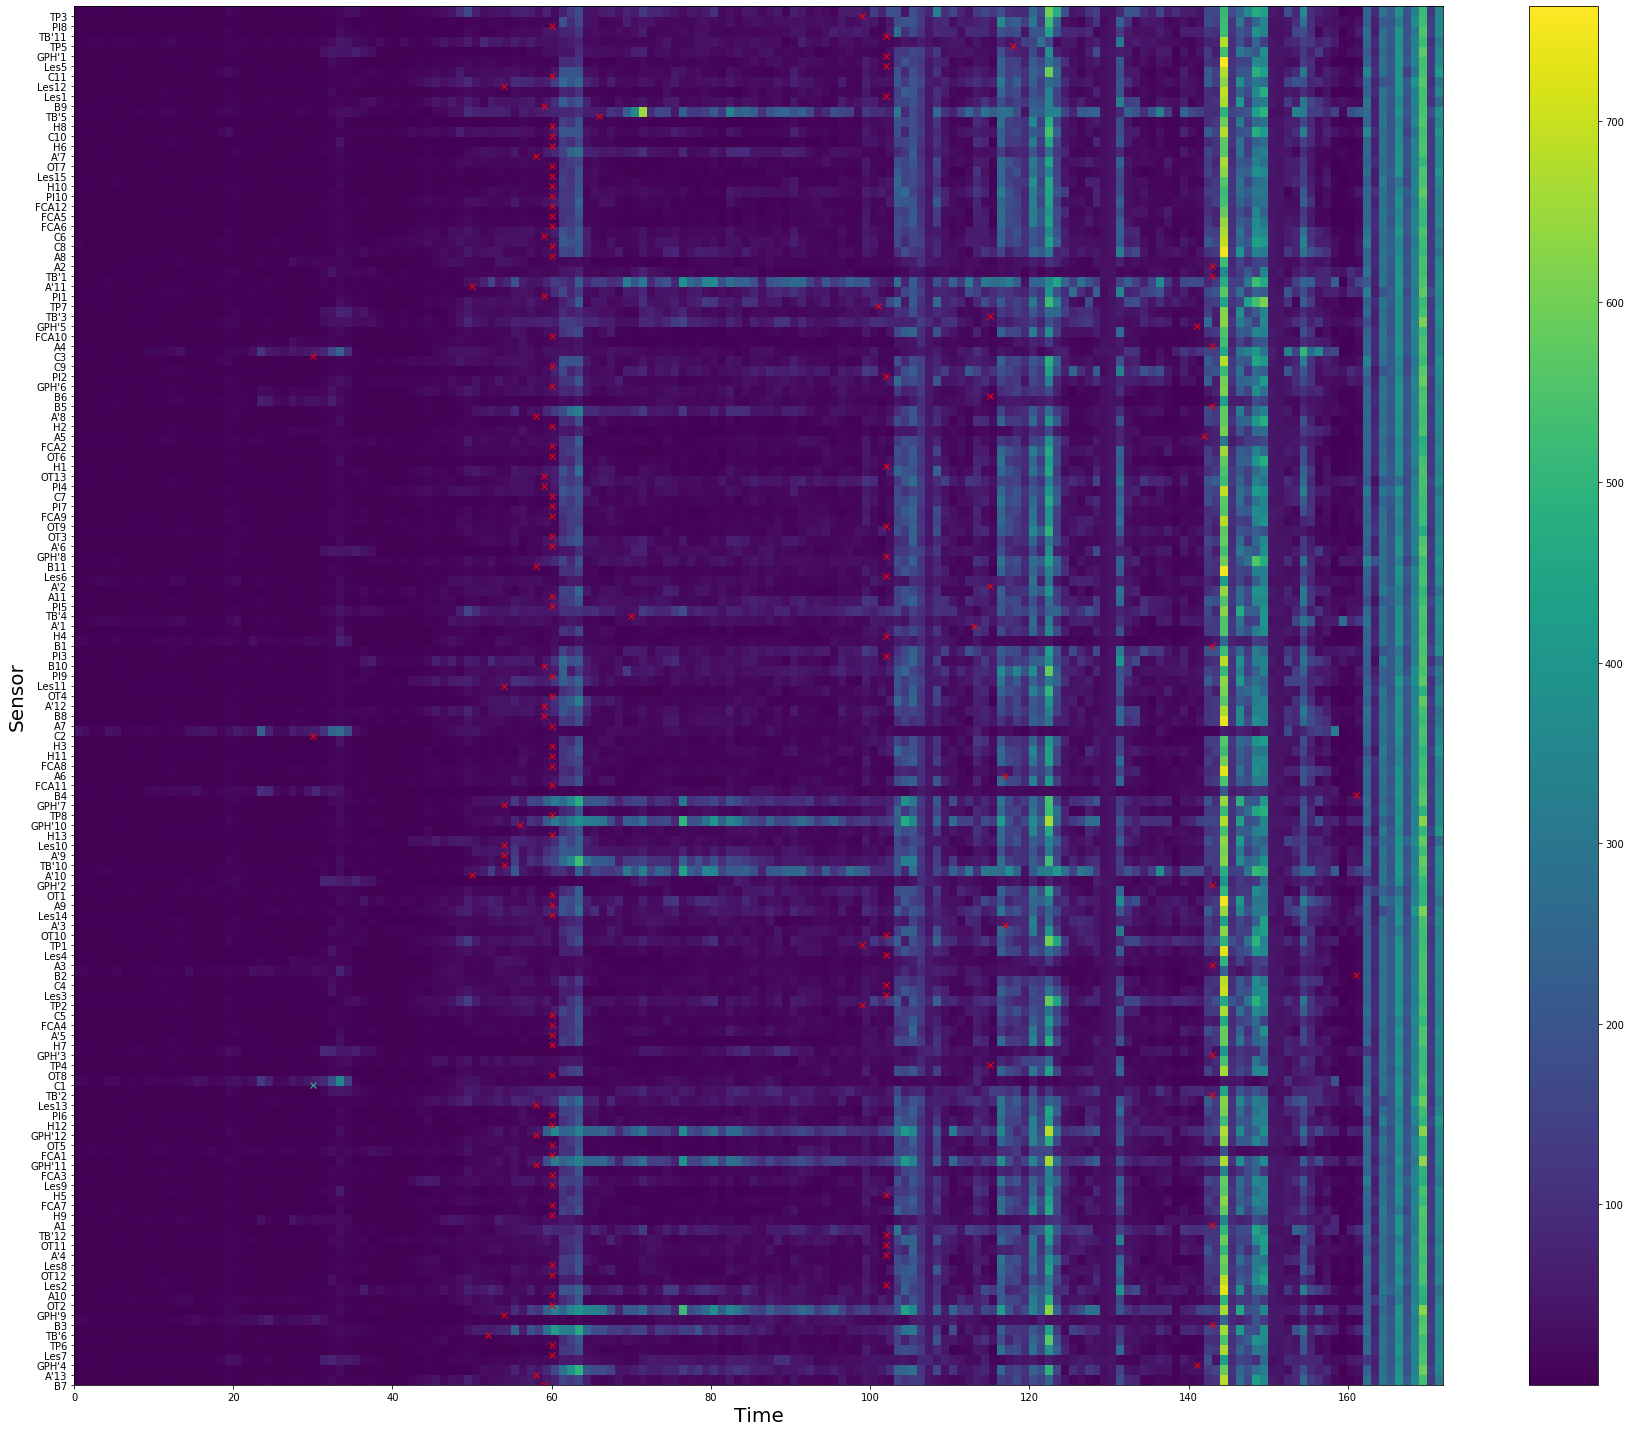

In [4]:
import importlib
importlib.reload(lib.utils.ez_priors)

ep_idx, Nd, N0, ER = lib.utils.ez_priors.comp_epindx(
    data_dir,
    raw_seeg_fname,
    meta_data_fname,
    bias=50,
    thrshld=200,
    tau=1,
    wndw_len=1024,
    wndw_ovrlp=512,
    ei_wndw_len=5)
ep_idx_keys, ep_idx_vals = zip(*ep_idx.items())
ep_idx_vals = np.array(ep_idx_vals)
cntcts_file = os.path.join(data_dir, 'elec', 'seeg.xyz')
cntrs_zipfile = os.path.join(data_dir,'tvb', 'connectivity.vep.zip')
ez_names, ez_idcs = lib.utils.ez_priors.get_ez_from_epindx(ep_idx, 0.5, cntcts_file, cntrs_zipfile, dist_prcntl=3.0)
print(ez_names)
print(ez_idcs)
print(N0)
ez_clin_hyp = np.loadtxt(os.path.join(data_dir, 'tvb', 'ez_hypothesis.vep.txt'))
print(np.where(ez_clin_hyp))

plt.figure()
plt.hist(ep_idx_vals);
plt.savefig(os.path.join(results_dir,'figures','ei_hist.png'))

k, v = zip(*ER.items())
ER_mat = np.array(v)
plt.figure(figsize=(25,20))
plt.pcolormesh(ER_mat)
plt.plot([Nd[ch_name] for ch_name in k], np.r_[0:len(k)], 'rx')
plt.plot(N0[1], k.index(N0[0]),  'cx')
plt.yticks(ticks=np.r_[0:len(k)], labels=k);
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sensor',fontsize=20)
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'figures', 'Nd_ER.png'))

np.savez(os.path.join(results_dir, "ei_data.npz"), ez_idcs=np.array(ez_idcs), ez_names=ez_names, ch_names=k)

In [5]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
# data['x0_mu'][ez_prior[0]] = -1.5
data['x0_mu'][ez_idcs] = -1.5
input_Rfile = f'fit_data_{fname_suffix}.R'
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

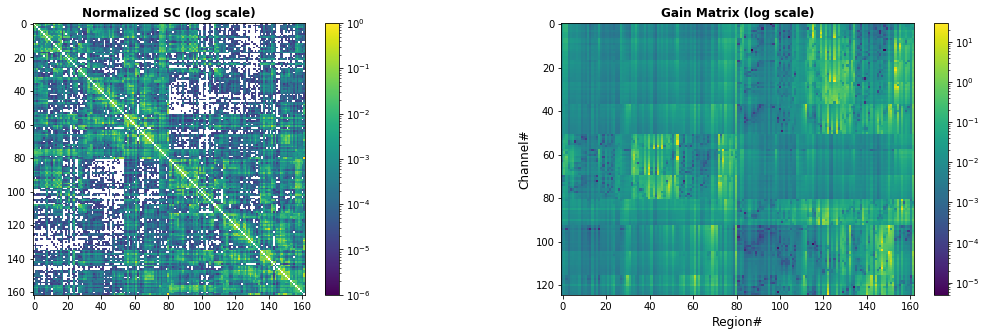

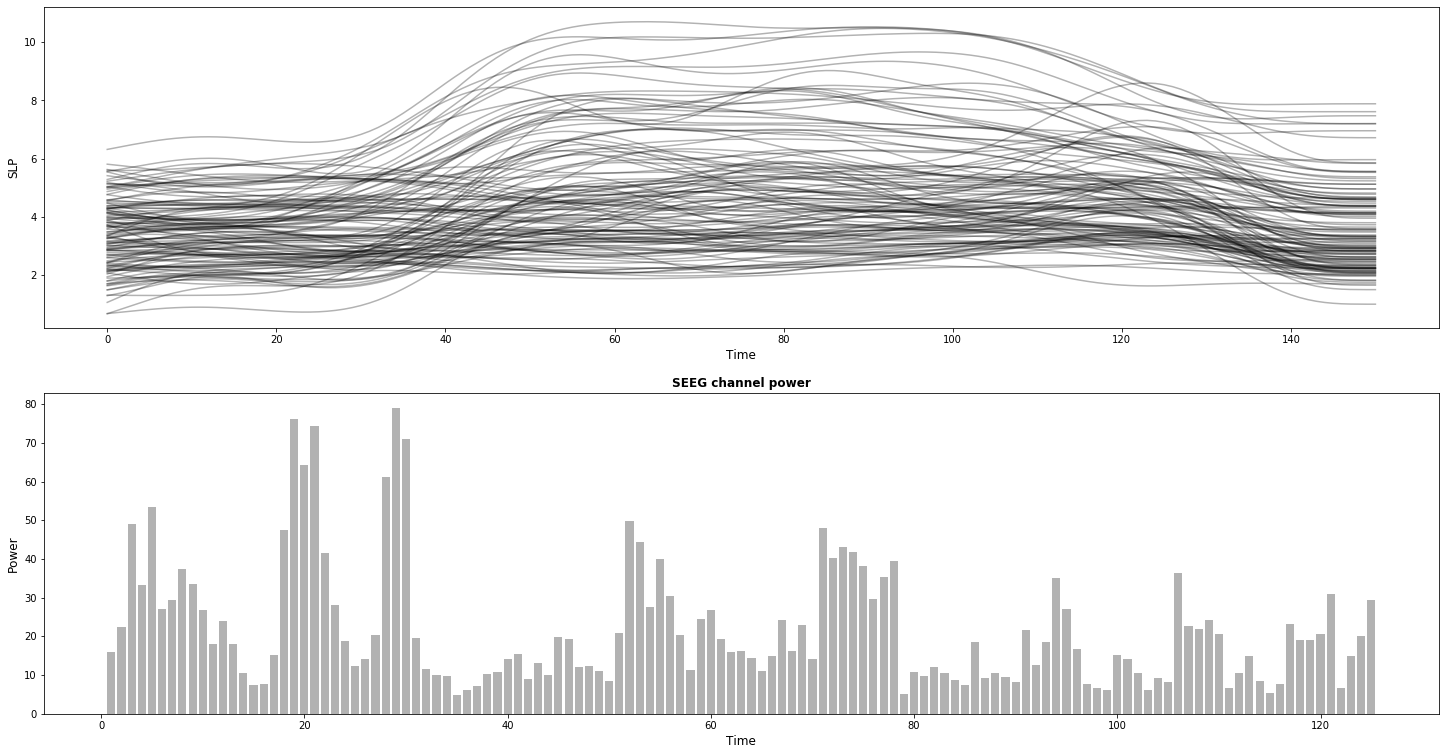

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


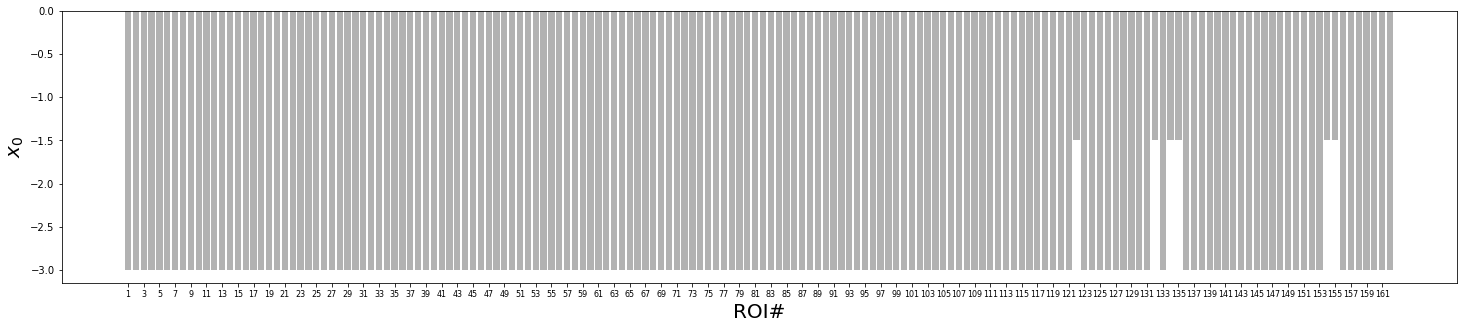

In [7]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#', fontsize=20)
plt.ylabel(r'$x_0$', fontsize=20)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [8]:
#stan_fname = 'vep-snsrfit-ode-nointerp'
stan_fname = 'szr_prpgtn'

x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}

param_init_file = 'param_init.R'

#lib.io.stan.rdump(f'{results_dir}/RfilesBT/param_init.R',param_init)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)



In [9]:
%%bash -s "$stan_fname" 

stancompile.sh $1

/home/anirudh/hdisk/Academia/projects/vep.stan
make: '/home/anirudh/hdisk/Academia/projects/vep.stan/szr_prpgtn' is up to date.


In [10]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4


./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/optima/samples_${FNAME_SUFFIX}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}.log